# Problem formulation

We seek to learn a POVM $\{E_m\}_{m=1}^M$, where $E_m \in \mathbb{C}^{N\times N}$, that describes a quantum measurement with $M$ outcomes from observed data $D$ from a set of probe states. 

A POVM must satisfy two criteria 

1) Each POVM element $E_m$ must be positive semi-definite 
2) The elements of the POVM must sum to the identity i.e. $\sum_{i=1}^ME_i=\mathbb{I}$

## Reimanian optimization

We can factorize each POVM element into a form that guarantees they remain positive semidefinte by factorizing them as

$$
E_m = A_m^\dag A_m \quad \text{cite the book thats better than mike and ike}
$$


to ensure that the second condition is met (completeness) we can define a matrix

$$
\mathcal{A} = 
\begin{bmatrix}
A_1  \\
\vdots \\
A_M
\end{bmatrix} \in \mathbb{C}^{MN \times N}
$$

for POVM elements $E_m$ to met the completeness criteria this vector must satfiy 

$$
\mathcal{A}^\dag\mathcal{A} = \begin{bmatrix}
A_1^\dag, \cdots, A_M^\dag  \end{bmatrix}
\begin{bmatrix}
A_1  \\
\vdots \\
A_M
\end{bmatrix} = \sum_{i=1}^M A_i^\dag A_i = \sum_{i=1}^M E_i = \mathbb{I}
$$


Since the matrix $\mathcal{A}$ must satisfy this relation it must also reside on the *Stiefel manifold* which is defined as

$$
St(n, p) = \{ W \in \mathbb{C}^{n\times p} | W^\dag W = \mathbb{I}_p \}
$$

that is, the set of complex $n \times p$ matrices $W$ that satisfy $W^\dag W = \mathbb{I}_p$ i.e. whose columns are orthonormal. Since we can parameterize our search space as the Stiefel manifold we can also perform optimization on this space using gradient based optimization methods as done in prior works on QST and QPT.

### Advantages of my approach

1) Compared to semidefinte programming the time complexity should be better allowing you to characterize more POVMs
2) Compared to the Nature Physics approach this allows one to reconstruct arbitrary POVMs not just ones that can be written diagonally in the Fock basis.

$L_1$ norm should work well for diagonal POVMs since it shrinks coefficients to $0$.

# Coherent state generation

In [847]:
from math import sqrt, gamma, exp

import numpy as np
import scipy
import matplotlib.pyplot as plt
from qutip import plot_wigner, Qobj

import torch as th
from torch import Tensor
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset

In [848]:
def coherent_ket(
    alpha: complex, dim: int, dtype: th.dtype = th.complex128
) -> Tensor:
    """
    Returns the ket of the coherent 
    state (displaced vacuum state): D(α)|0⟩
    Note that math.gamma(n) computes (n-1)! not n! so be careful.
    """

    const = exp(-(abs(alpha) ** 2) / 2.0)

    ket = th.tensor(
        [const * (alpha ** (n)) / sqrt(gamma(n + 1)) for n in range(dim)], dtype=dtype
    )

    norm = th.linalg.norm(ket)
    ket /= norm  # normalize ket

    return ket

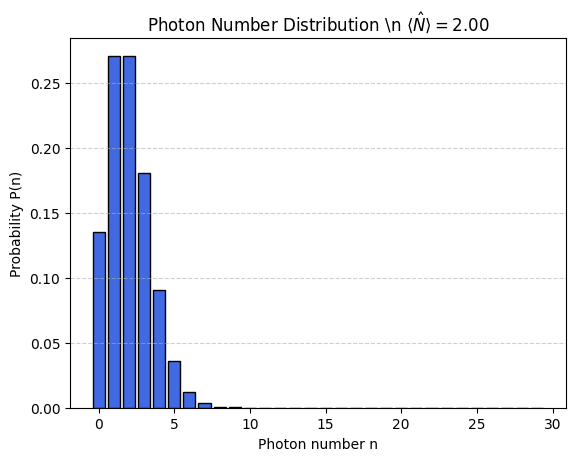

In [849]:
dim = 30
psi = coherent_ket(1.0 + 1.0j, dim)
n = np.arange(dim)
P_n = (th.abs(psi) ** 2).numpy()

plt.bar(n, P_n, color='royalblue', edgecolor='k')
plt.xlabel('Photon number n')
plt.ylabel('Probability P(n)')
plt.title(r'Photon Number Distribution \n $\langle \hat{N} \rangle =$' + f'{sum(n * P_n):.2f}')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show();

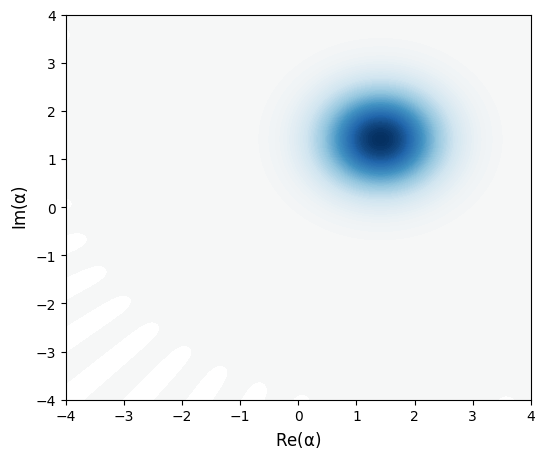

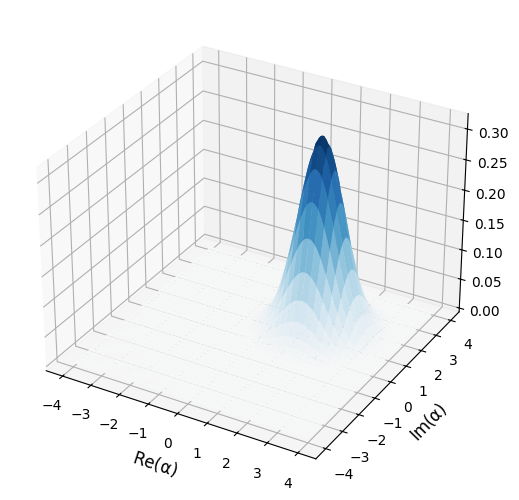

In [850]:
xvec = np.linspace(-4, 4, 200)
plot_wigner(Qobj(psi.numpy()), xvec, xvec, projection='2d', fig=plt.figure(figsize=(6,5)))
plot_wigner(Qobj(psi.numpy()), xvec, xvec, projection='3d');

In [851]:
N = 20
E = th.zeros((N,N), dtype=th.complex64)
E[0,0] = 1.0
vac = coherent_ket(1.0, N, dtype=th.complex64)
print(vac)
print(vac.conj() @ E @ vac)

tensor([6.0653e-01+0.j, 6.0653e-01+0.j, 4.2888e-01+0.j, 2.4762e-01+0.j, 1.2381e-01+0.j,
        5.5368e-02+0.j, 2.2604e-02+0.j, 8.5435e-03+0.j, 3.0206e-03+0.j, 1.0069e-03+0.j,
        3.1840e-04+0.j, 9.6001e-05+0.j, 2.7713e-05+0.j, 7.6862e-06+0.j, 2.0542e-06+0.j,
        5.3040e-07+0.j, 1.3260e-07+0.j, 3.2160e-08+0.j, 7.5802e-09+0.j, 1.7390e-09+0.j])
tensor(0.3679+0.j)


# Random POVM generation

In [852]:
def random_povm(N: int, M: int) -> list[Tensor]:
    """
    Generate a random POVM {E_i} on an N-dimensional Hilbert space
    with M outcomes.
    """
    # Step 1: random positive semidefinite operators
    Fs = []
    for _ in range(M):
        real_part = th.randn(N, N)
        imag_part = th.randn(N, N)
        A = (real_part + 1j * imag_part) / sqrt(2.0)
        F = (A.H @ A).to(dtype=th.complex128)  # Hermitian, PSD
        Fs.append(F)

    # Step 2: normalize so they sum to identity
    S = sum(Fs)
    # matrix square root inverse
    sqrtS = th.tensor(scipy.linalg.sqrtm(S).astype(np.complex128))
    S_inv_sqrt = th.linalg.inv(sqrtS).to(dtype=th.complex128)
    Es = [S_inv_sqrt @ F @ S_inv_sqrt for F in Fs]

    return Es

In [853]:
def random_stiefel(rows: int, cols: int, dtype: th.dtype = th.float64) -> th.Tensor:
    """
    Generates a random matrix from the Stiefel manifold 
    St(rows,  cols) i.e. a random complex matrix with orthonormal columns.

    Args:
        rows: The number of rows in the matrix.
        cols: The number of columns in the matrix.

    Returns:
        Tensor: A complex matrix with orthonormal columns.
    """
    # Generate a random complex matrix
    # Real and imaginary parts are drawn from a standard normal distribution
    random_real = th.randn(rows, cols, dtype=dtype)
    random_imag = th.randn(rows, cols, dtype=dtype)
    random_complex_matrix = th.complex(random_real, random_imag)

    # Perform QR decomposition
    # The 'Q' matrix will have orthonormal columns
    Q, _ = th.linalg.qr(random_complex_matrix)

    return Q

def check_povm_validity(povm: list[th.Tensor], tol: float = 1e-6) -> bool:
    """
    Check if a given POVM is valid.

    Args:
        povm: List of POVM elements (tensors).
        tol: Tolerance for numerical checks.    
    Returns:
        bool: True if the POVM is valid, False otherwise. 
    """
    # Check positivity
    for E in povm:
        eigenvalues = th.linalg.eigvalsh(E)
        if th.any(eigenvalues < -tol):
            print("POVM element is not positive semi-definite.")
            return False

    # Check completeness
    identity = th.eye(povm[0].shape[0], dtype=povm[0].dtype)
    sum_E = sum(povm)
    if th.linalg.norm(sum_E - identity, ord='fro') > tol:
        print("POVM elements do not sum to identity.")
        return False

    return True

In [854]:
D = 500
Q = random_stiefel(D, D)

identity_check = Q.H @ Q
print(f"||I - Q†Q:||_2 = {th.linalg.norm(identity_check - th.eye(D), ord=2)}")

||I - Q†Q:||_2 = 4.568821248114686e-15


In [855]:
import torch
import matplotlib.pyplot as plt

def plot_matrices_side_by_side(A, B, titles=('Matrix A', 'Matrix B'), show_diff=False):
    """
    Plot two matrices side-by-side for comparison.

    Args:
        A, B: torch.Tensor or np.ndarray of shape (N, N)
        titles: tuple of two strings for subplot titles
        show_diff: whether to also show |A - B| difference as a third panel
    """
    A = A.detach().cpu()
    B = B.detach().cpu()

    # If complex, show magnitude
    if torch.is_complex(A):
        A = A.abs()
        B = B.abs()

    ncols = 3 if show_diff else 2
    fig, axes = plt.subplots(1, ncols, figsize=(5 * ncols, 4))

    im0 = axes[0].imshow(A, cmap='RdBu', origin='lower')
    axes[0].set_title(titles[0])
    fig.colorbar(im0, ax=axes[0])

    im1 = axes[1].imshow(B, cmap='RdBu', origin='lower')
    axes[1].set_title(titles[1])
    fig.colorbar(im1, ax=axes[1])

    if show_diff:
        diff = (A - B).abs()
        im2 = axes[2].imshow(diff, cmap='magma', origin='lower')
        axes[2].set_title('|A - B| difference')
        fig.colorbar(im2, ax=axes[2])

    plt.tight_layout()
    plt.show()

## Test

In [856]:
from IPython.display import Math

def numpy_to_latex_matrix(array):
    """
    Converts a NumPy 2D array to a LaTeX bmatrix string.
    """
    if len(array.shape) != 2:
        raise ValueError("Input must be a 2D NumPy array.")

    # Convert array elements to strings and join with '&' for columns
    rows = [' & '.join(map(str, row)) for row in array]
    
    # Join rows with '\\\\' for new lines in LaTeX
    matrix_content = ' \\\\\n'.join(rows)
    
    # Enclose in \begin{bmatrix} and \end{bmatrix}
    latex_string = f"\\begin{{bmatrix}}\n{matrix_content}\n\\end{{bmatrix}}"
    return latex_string


N = 2   # Hilbert space dimension
M = 4   # number of POVM outcomes

povm = random_povm(N, M)
# Convert to QuTiP Qobj
povm = [Qobj(E) for E in povm]


# Check the POVM conditions
print("Sum of elements:\n", sum(povm).full())
# Convert to LaTeX string
sum_Es = np.round(sum(povm).full(), decimals=8)
latex_matrix_str =  numpy_to_latex_matrix(sum_Es)

# Display in Jupyter notebook
display(Math(latex_matrix_str))

print("\n|I - \sum E|=", np.linalg.norm(sum(povm).full() - np.eye(N)))

tol=1e-9
is_psd = True
for E in povm:
    eigenvalues = np.linalg.eigvalsh(E.full())
    # Check if all eigenvalues are non-negative (within tolerance)
    if all(eig >= -tol for eig in eigenvalues):
        continue
    else:
        is_psd = False
        break


if is_psd:
    print("\nObject is positive semidefinite.")
else:
    print("\nObject is not positive semidefinite.")


print("\nHermiticity check:", all(E.isherm for E in povm))
print("\nTrace sum:", (sum(povm)).tr())  # should equal N

Sum of elements:
 [[1.00000000e+00+4.33680869e-18j 2.49800181e-16-6.24500451e-17j]
 [3.74700271e-16+1.17961196e-16j 1.00000000e+00-5.20417043e-18j]]


<IPython.core.display.Math object>


|I - \sum E|= 1.2847067981224735e-15

Object is positive semidefinite.

Hermiticity check: True

Trace sum: 2.0000000000000018


# Loss function

In [857]:
# def povm_loss(targets: Tensor, factors: Tensor, probes: Tensor, lam: float) -> Tensor:
#     """
#     Differentiable loss for POVM optimization (vectorized).

#     Args:
#         targets: (num_probes, M) real tensor — target probabilities.
#         probes: (num_probes, N) complex tensor — probe state amplitudes.
#         factors: (M*N, N) complex tensor — stacked POVM factors.
#         lam: regularization parameter.

#     Returns:
#         Differentiable scalar tensor
#     """
#     M = targets.shape[1]
#     N = probes.shape[1] 

#     # Reshape factors into (M, N, N)
#     factors = [factors[i*N:(i+1)*N, :] for i in range(M)]
#     # Compute POVM elements E_m = A_m† A_m  → shape (M, N, N)
#     povm = [factor.H @ factor for factor in factors] 

#     # Compute probabilities: p_i(m) = <ψ_i | E_m | ψ_i>
#     # Result shape: (num_probes, M)
#     # probs = th.einsum("bi,mij,bj->bm", probes.conj(), povms, probes).real
#     pred_probs = []
#     for probe in probes:
#         probe_pred_probs = [] 
#         for E in povm:
#             prob = th.real((probe.conj().T @ E @ probe))
#             probe_pred_probs.append(prob)
        
#         probe_pred_probs = th.tensor(probe_pred_probs)
#         pred_probs.append(probe_pred_probs)
    
#     pred_probs = th.vstack(pred_probs)

#     # Squared error term
#     sq_err = th.sum((pred_probs - targets) ** 2)

#     # L1 regularization
#     reg = th.sum(th.linalg.matrix_norm(th.cat(factors), ord=1))

#     return 1*(sq_err + lam * reg)


def povm_loss(targets: Tensor, factors: Tensor, probes: Tensor, lam: float) -> Tensor:
    """
    Differentiable loss for POVM optimization (vectorized).

    Args:
        targets: (num_probes, M) real tensor — target probabilities.
        probes: (num_probes, N) complex tensor — probe state amplitudes.
        factors: (M*N, N) complex tensor — stacked POVM factors.
        lam: regularization parameter.

    Returns:
        Differentiable scalar tensor
    """
    N = probes.shape[1]
    M = targets.shape[1]

    # Reshape factors into (M, N, N)
    factors = factors.view(M, N, N)

    # Compute POVM elements E_m = A_m† A_m → shape (M, N, N)
    povm = th.matmul(factors.conj().transpose(-1, -2), factors)

    # Compute predicted probabilities:
    # p_i(m) = <ψ_i| E_m |ψ_i>
    # Einsum pattern explanation:
    #   b = batch (probe index)
    #   m = POVM element index
    #   i,j = Hilbert indices
    pred_probs = th.einsum("bi,mij,bj->bm", probes.conj(), povm, probes).real

    # Squared error loss
    sq_err = th.sum((pred_probs - targets) ** 2) / M
    #sq_err = th.linalg.matrix_norm(pred_probs - targets, ord='fro')
    # L1 regularization on all factors
    reg = th.sum(th.abs(povm))

    # Total loss (negative for maximization if needed)
    return 1*(sq_err + lam * reg)


In [858]:
N = 20
R = 4.0

def circle_points(N: int, R: float = 1.0):
    """
    Return N evenly spaced points on a circle of radius R in the complex plane.
    """
    angles = np.linspace(0, 2*np.pi, N, endpoint=False)
    points = R * np.exp(1j * angles)
    return points

points = circle_points(N, R)

# Plot
# plt.figure(figsize=(5,5))
# plt.scatter(points.real, points.imag, color='royalblue', s=60, label='Circle points')
# plt.plot(R*np.cos(np.linspace(0,2*np.pi,200)),
#          R*np.sin(np.linspace(0,2*np.pi,200)),
#          'k--', alpha=0.5, label='Circle (radius R)')

# Aesthetics
# plt.xlabel('Re(z)', fontsize=12)
# plt.ylabel('Im(z)', fontsize=12)
# plt.title(f'{N} Evenly Spaced Points on Circle (R={R})', fontsize=14)
# plt.axis('equal')
# plt.grid(True, linestyle='--', alpha=0.5)
# plt.legend()
# plt.show()

# Training loop

In [859]:
N = 50  # Hilbert space dimension
M = 9  # number of POVM/measurement outcomes

## True POVM

In [860]:
# make POVM of perfect PNR measurement in the Fock basis
# true_povm = [] 
# for i in range(M):
#     diag = th.zeros((N,), dtype=th.complex128)
#     diag[i] = 1.0
#     E = th.diag(diag)
#     true_povm.append(E)

# or use random POVM
true_povm = random_povm(N, M) 

print(f'Are true POVM valid? {"Yes" if check_povm_validity(true_povm) else "No"}')

Are true POVM valid? Yes


## Initial random POVM

|| I - A†A ||2: 1.5328582047474213e-15
POVM factors matrix shape: [450, 50]


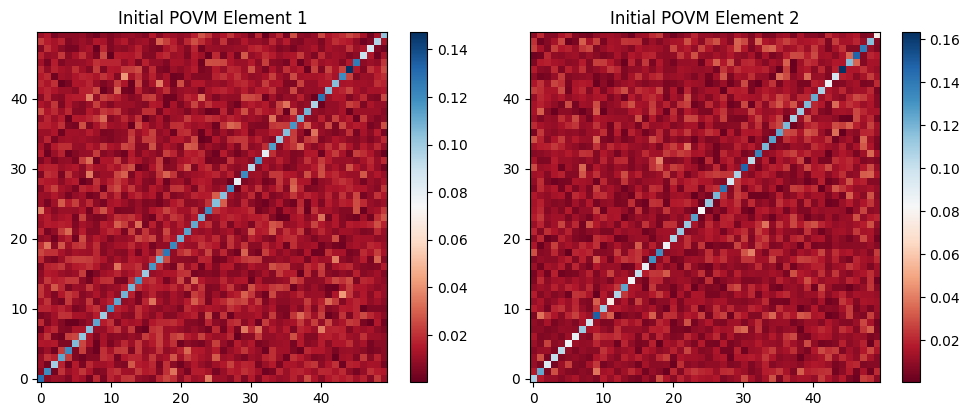

In [861]:
# generate initial random povm factors i.e. matrix with orthonormal columns
factors = random_stiefel(M*N, N)
factors.requires_grad = True

print(f"|| I - A†A ||2: {th.linalg.norm(th.eye(N) - factors.H @ factors, ord=2).item()}")

print(f"POVM factors matrix shape: {list(factors.shape)}")

_factors = factors.view(M, N, N)
_povm = th.matmul(_factors.conj().transpose(-1, -2), _factors)
plot_matrices_side_by_side(_povm[0], _povm[1],  titles=(f'Initial POVM Element 1', f'Initial POVM Element 2'))

## Create probe states

In [862]:
num_probes = 15
# generate num_probes^2 state probes each from circles of increasing radius
complex_amps = np.array([circle_points(num_probes, R=R) for R in np.linspace(0, 4, num_probes) ]).flatten()
# complex_amps = np.linspace(0, 4.0, num_probes)
probes = th.vstack([ coherent_ket(alpha, N) for alpha in complex_amps ])
print(f"Shape of probes is: {list(probes.shape)} should be {[num_probes**2, N]}.")

Shape of probes is: [225, 50] should be [225, 50].


## Create target expectation matrix

In [863]:
targets = []
for probe in probes:
    probe_probs = []
    for E in true_povm:
        prob = th.real((probe.conj().T @ E @ probe))
        probe_probs.append(prob)
    probe_probs = th.tensor(probe_probs)
    targets.append(probe_probs)

targets = th.stack(targets, dim=0).real

print(f"Shape of targets is: {list(targets.shape)} should be {[num_probes**2, M]}.")

for i in range(targets.shape[0]):
    if th.sum(targets[0]).item() - 1.0 > 1e-6:
        print(f"Warning: Sum of target probabilities for probe {i} is {th.sum(targets[i]).item()} (should be 1.0)")

Shape of targets is: [225, 9] should be [225, 9].


In [864]:
lr = 0.001 # learning rate
lam = 0*1e-3  # regularization weight

optimizer = th.optim.SGD([factors], lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.99) # Decay LR by gamma every time called

dataset = TensorDataset(probes, targets)

# Create DataLoader
batch_size = 50
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

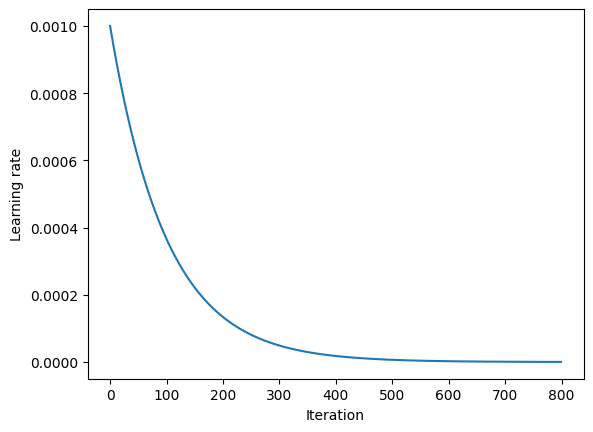

In [865]:
iterations = 800
losses = []
lr_vals = []

for step in range(iterations):
    for param_group in optimizer.param_groups:
        # NOTE: This is needed if using adaptive learning rate optimizers like Adam or learning rate
        # schedulers as the lr is needed to compute the retraction step
        current_lr = param_group['lr']
        lr_vals.append(current_lr)


    completeness_cond = th.linalg.norm(th.eye(N) - factors.H @ factors, ord=2).item()
    if completeness_cond > 1e-5:
        print(f"Warning: POVM not valid at step {step+1} is: {completeness_cond}") 
    
    batch_losses = []

    for probes_batch, targets_batch in loader:
        optimizer.zero_grad()

        # Compute batch loss
        L = povm_loss(targets_batch, factors, probes_batch, lam)
        L.backward()

        # --- Retraction step ---
        normed_G = factors.grad / th.linalg.norm(factors.grad, ord=2)
        A = th.hstack([normed_G, factors])      # (M*N, 2N)
        B = th.hstack([factors, -normed_G])     # (M*N, 2N)

        # Conjugate gradient retraction
        inv_term = th.linalg.inv(th.eye(2*N, dtype=th.cfloat) + (current_lr/2)*(B.conj().T @ A))
        factors.grad = A @ inv_term @ B.conj().T @ factors

        optimizer.step()
        batch_losses.append(L.item())

    scheduler.step()
    losses.append(sum(batch_losses) / len(batch_losses))
    

plt.ylabel('Learning rate')
plt.xlabel('Iteration')
plt.plot(lr_vals);

Final loss: 0.00045388237878942237


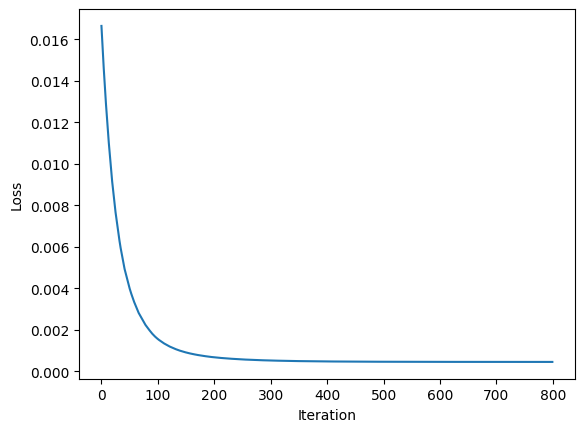

In [866]:
print("Final loss:", losses[-1])
# plt.yscale('log')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.plot(losses);

|| I - ΣAi†Ai ||2: 2.9885989045869093e-15
True
[0.6006157846907462, 0.5791556417721485, 0.5923828947536428, 0.5795003877236689, 0.5723889975652472, 0.5977214184416292, 0.5725660845839837, 0.6073733752225147, 0.5800622949837702]
[0.8532673682960465, 0.8502126754858444, 0.8263554487977037, 0.856461655148377, 0.8392199483659685, 0.8520420607422485, 0.8627341435622369, 0.8135237225843522, 0.8476024856047857]


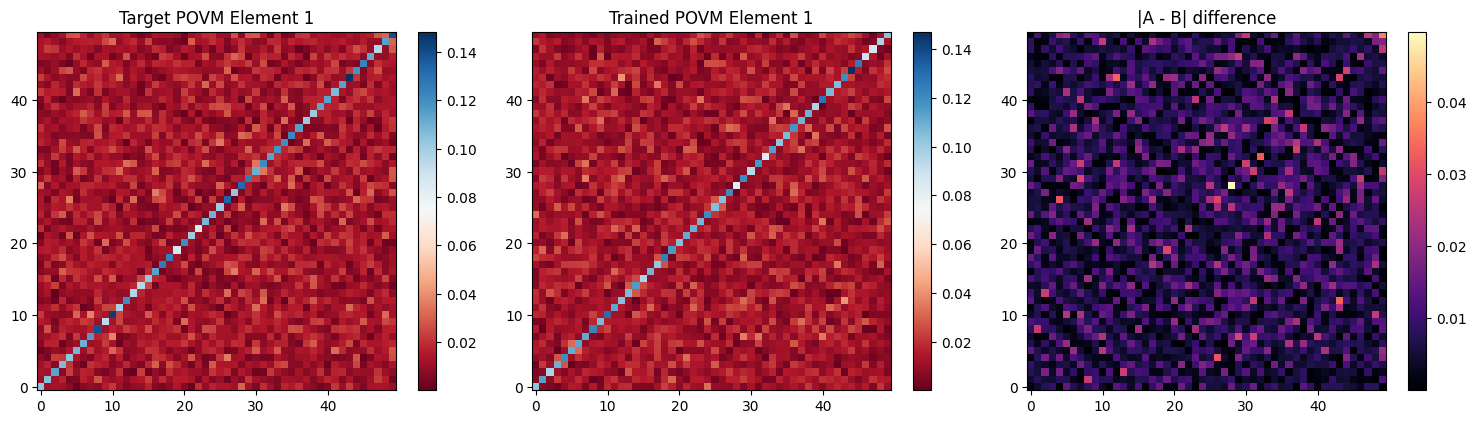

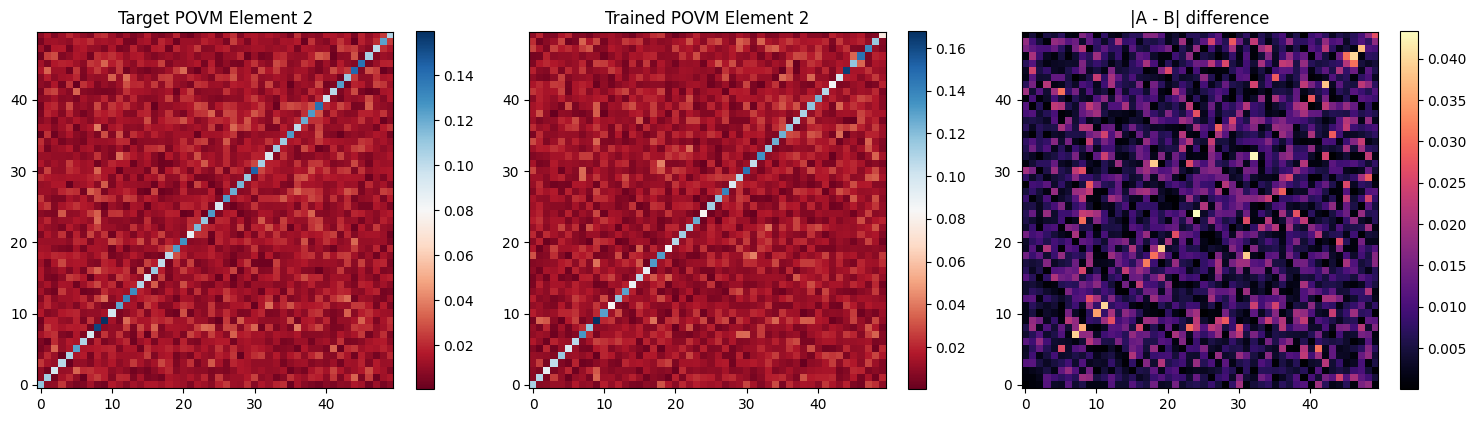

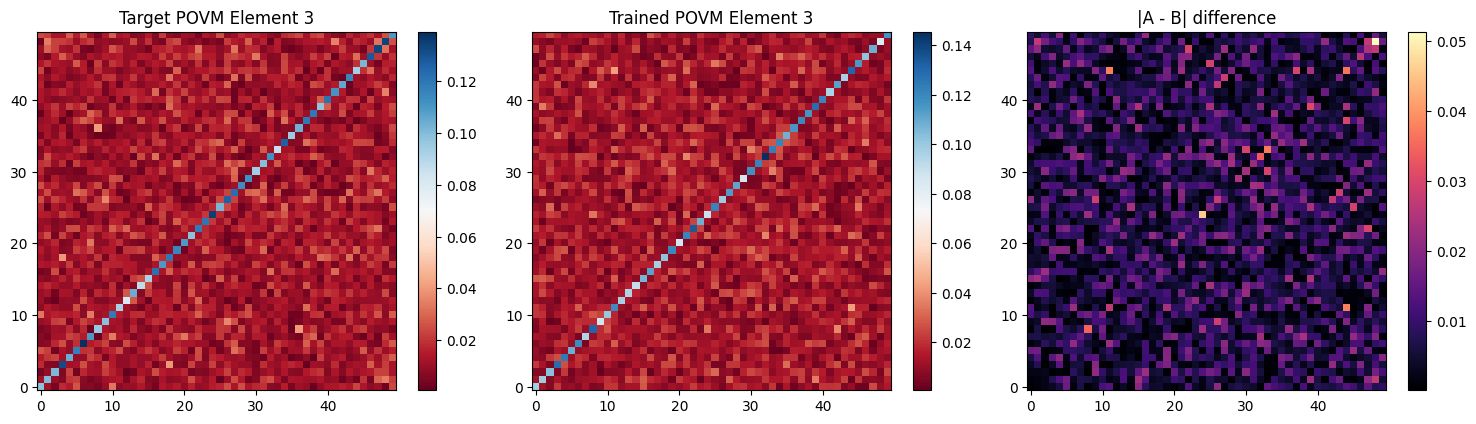

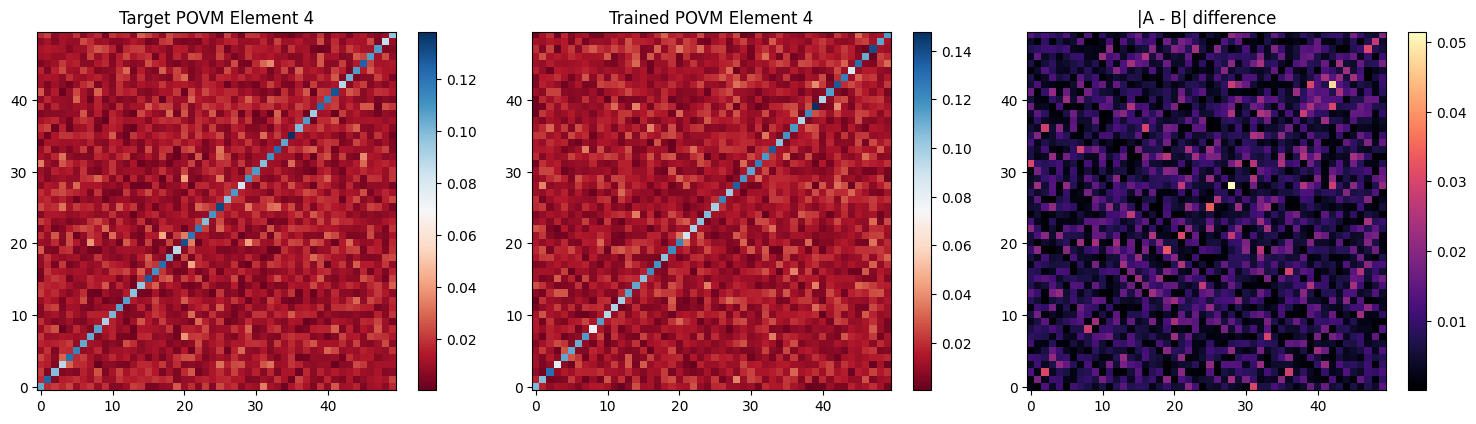

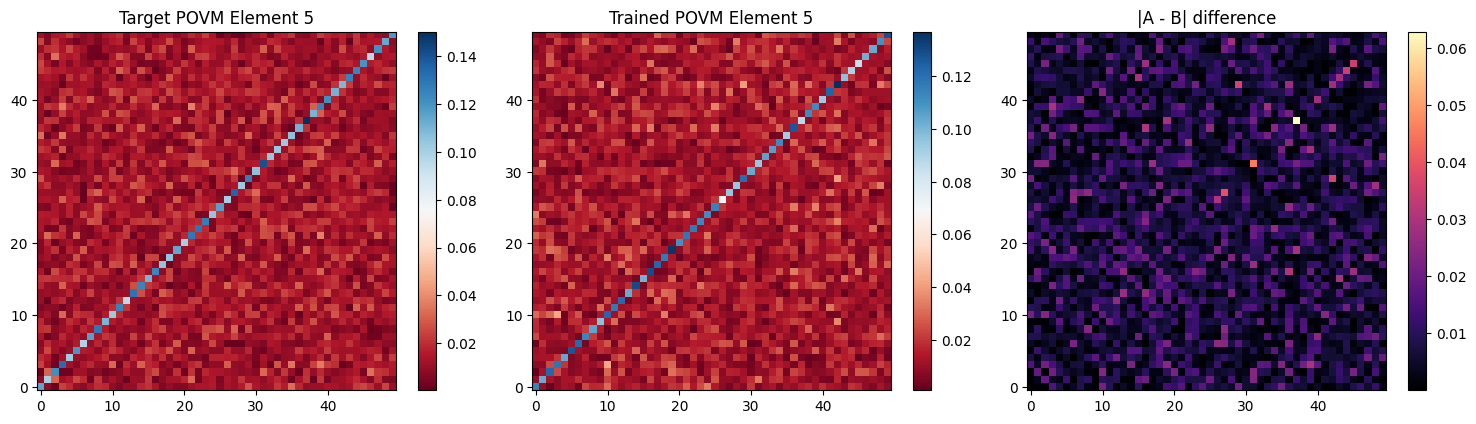

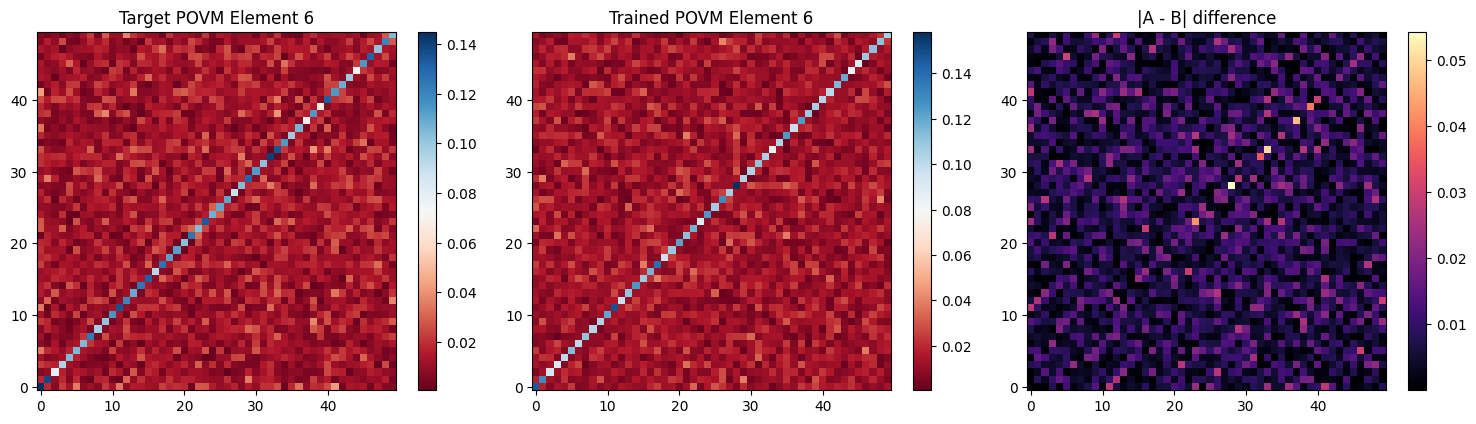

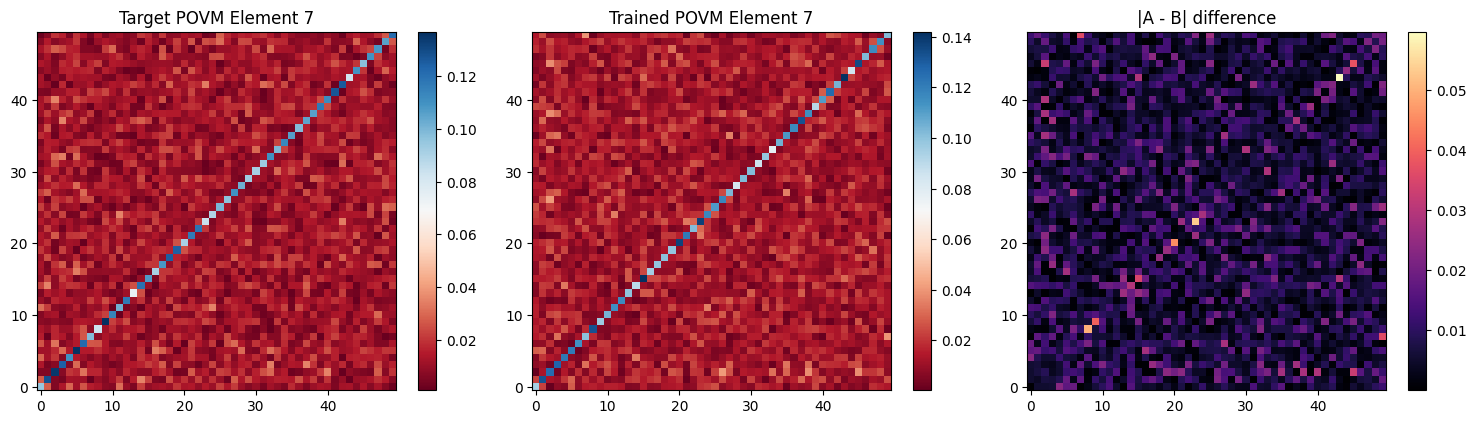

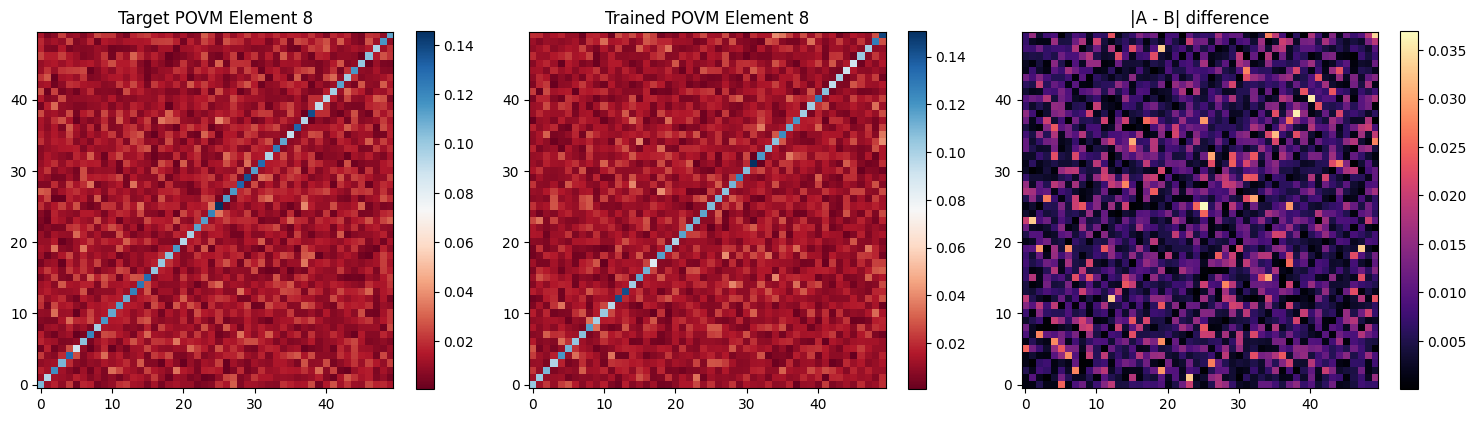

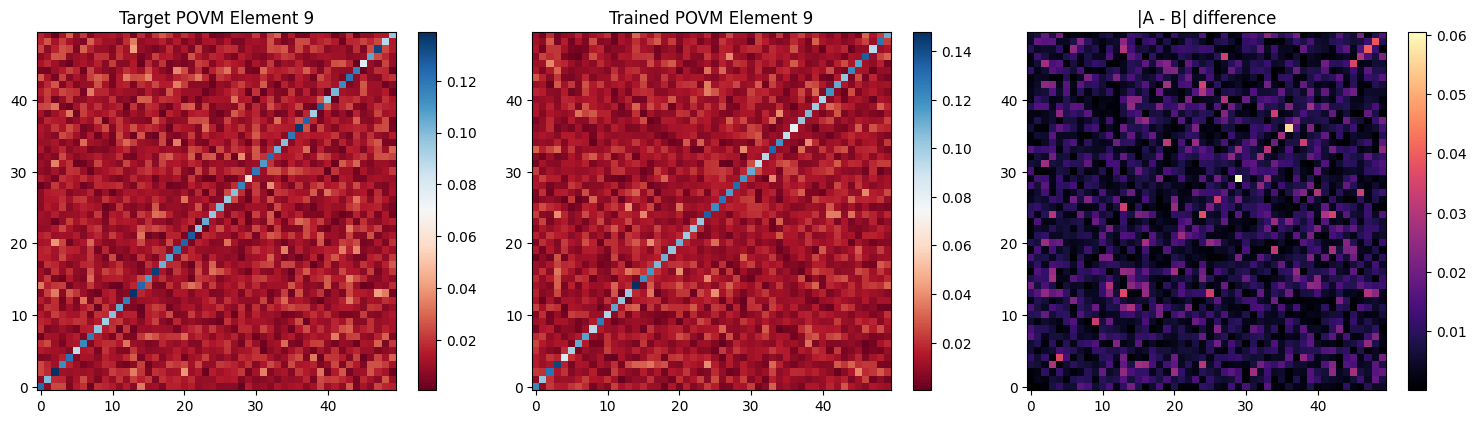

In [867]:
from qutip import fidelity, Qobj

with th.no_grad():
    factors = factors.view(M, N, N)
    converged_povm = th.matmul(factors.conj().transpose(-1, -2), factors)
    print(f"|| I - ΣAi†Ai ||2: {th.linalg.norm(th.eye(N) - sum(converged_povm), ord=2).item()}")
    print(check_povm_validity(converged_povm, tol=1e-6))
    #converged_povm = np.array([ factor.H @ factor for factor in converged_factors ])
    print([ th.real(fidelity(Qobj(converged_povm[i]), Qobj(true_povm[i]))**2 / (th.trace(true_povm[i])*th.trace(converged_povm[i]))).item() for i in range(M) ])
    print([ th.linalg.norm(converged_povm[i] - true_povm[i], ord=2).item() / th.linalg.norm(true_povm[i], ord=2).item() for i in range(M) ])
    
    for i in range(M):
        plot_matrices_side_by_side(true_povm[i], converged_povm[i],  titles=(f'Target POVM Element {i+1}', f'Trained POVM Element {i+1}'), show_diff=True)